# StepFunctions Data Science SDK for BYO Container

Here we demonstrate how to use the StepFunction Data Science SDK to do an end-to-end data science workflow where you bring your own code and deploy a model on SageMaker.

The Steps are as follows:

1. Create a Lambda function which launches a CodeBuild job that launches the creation of your Docker container. (Steps for this are included separately)
2. Launch the Lambda function as a Step Functions workflow. 
3. Once the Docker container is built, launch a SageMaker training job using SF DS SDK.
4. Use the DS SDK to deploy the trained model.

## Create an execution role for Step Functions

You need an execution role so that you can create and execute workflows in Step Functions.

1. Go to the IAM console
2. Select Roles and then Create role.
3. Under Choose the service that will use this role select Step Functions
4. Choose Next until you can enter a Role name
5. Enter a name such as StepFunctionsWorkflowExecutionRole and then select Create role

Attach a policy to the role you created. The following steps attach a policy that provides full access to Step Functions, however as a good practice you should only provide access to the resources you need.

1. Under the Permissions tab, click Add inline policy
2. Enter the following in the JSON tab

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateTransformJob",
                "sagemaker:DescribeTransformJob",
                "sagemaker:StopTransformJob",
                "sagemaker:CreateTrainingJob",
                "sagemaker:DescribeTrainingJob",
                "sagemaker:StopTrainingJob",
                "sagemaker:CreateHyperParameterTuningJob",
                "sagemaker:DescribeHyperParameterTuningJob",
                "sagemaker:StopHyperParameterTuningJob",
                "sagemaker:CreateModel",
                "sagemaker:CreateEndpointConfig",
                "sagemaker:CreateEndpoint",
                "sagemaker:DeleteEndpointConfig",
                "sagemaker:DeleteEndpoint",
                "sagemaker:UpdateEndpoint",
                "sagemaker:ListTags",
                "lambda:InvokeFunction",
                "sqs:SendMessage",
                "sns:Publish",
                "ecs:RunTask",
                "ecs:StopTask",
                "ecs:DescribeTasks",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:UpdateItem",
                "dynamodb:DeleteItem",
                "batch:SubmitJob",
                "batch:DescribeJobs",
                "batch:TerminateJob",
                "glue:StartJobRun",
                "glue:GetJobRun",
                "glue:GetJobRuns",
                "glue:BatchStopJobRun"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "*",
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "sagemaker.amazonaws.com"
                }
            }
        },
        {
            "Effect": "Allow",
            "Action": [
                "events:PutTargets",
                "events:PutRule",
                "events:DescribeRule"
            ],
            "Resource": [
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTrainingJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTransformJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTuningJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForECSTaskRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForBatchJobsRule"
            ]
        }
    ]
}
```

1. Choose Review policy and give the policy a name such as StepFunctionsWorkflowExecutionPolicy
2. Choose Create policy. You will be redirected to the details page for the role.
2. Note the Role ARN at the top of the Summary, as you'll need it later.


## Import necessary libraries

In [1]:
%matplotlib inline

# Import required libraries and upload the training data to S3
import boto3
import os
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import time
import uuid
import matplotlib.pyplot as plt
from PIL import Image

role = get_execution_role()
sess = sagemaker.Session()
bucket = sess.default_bucket() # or feel free to replace with a bucket of your choosing
WORK_DIRECTORY = 'PennFudanPed'
key = 'BYO-Mask-RCNN'
prefix = '{}/{}'.format(key, WORK_DIRECTORY)

In [2]:
print(bucket)
print(WORK_DIRECTORY)
print(key)
print(prefix)

sagemaker-us-east-1-113147044314
PennFudanPed
BYO-Mask-RCNN
BYO-Mask-RCNN/PennFudanPed


In [3]:
# install StepFunctions SDK
import sys
!{sys.executable} -m pip install --upgrade stepfunctions

    100% |████████████████████████████████| 61kB 10.4MB/s ta 0:00:01
Requirement not upgraded as not directly required: sagemaker>=1.42.8 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from stepfunctions) (1.50.12)
Requirement not upgraded as not directly required: boto3>=1.9.213 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from stepfunctions) (1.12.2)
Requirement not upgraded as not directly required: pyyaml in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from stepfunctions) (5.2)
Requirement not upgraded as not directly required: packaging>=20.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from sagemaker>=1.42.8->stepfunctions) (20.1)
Requirement not upgraded as not directly required: importlib-metadata>=1.4.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from sagemaker>=1.42.8->stepfunctions) (1.5.0)
Requirement not upgraded as not directly required: scipy>=0.19.0 i

## Find your StepFunctionsWorkflowExecutionRole ARN

Go back to IAM and find the ARN of the role where you created the inline policy above. 

You can find the full ARN in the top of that IAM page.

In [4]:
import stepfunctions
import logging
from stepfunctions.steps import (LambdaStep, Retry, Catch, Fail, Chain, TrainingStep, ModelStep, EndpointConfigStep, EndpointStep)
from stepfunctions.workflow import Workflow
from stepfunctions.template.pipeline import TrainingPipeline
from stepfunctions.inputs import ExecutionInput

stepfunctions.set_stream_logger(level=logging.INFO)

# paste the StepFunctionsWorkflowExecutionRole ARN from above in "<>"
workflow_execution_role = "arn:aws:iam::113147044314:role/StepFunctionsWorkflowExecutionRole" 

## Download the training data

In [5]:
!rm -rf PennFudanPed*
!wget "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
!unzip PennFudanPed.zip

--2020-02-24 23:52:00--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  4.75MB/s    in 9.0s    

2020-02-24 23:52:09 (5.67 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

## Upload the training dataset to Amazon S3

After executing the cell below, wait until the `data_location` variable is printed, or until the S3 bucket is populated. You can check this by opening S3 in another browser tab.

In [6]:
data_location = sess.upload_data(WORK_DIRECTORY, bucket=bucket, key_prefix=prefix)
print(data_location)

s3://sagemaker-us-east-1-113147044314/BYO-Mask-RCNN/PennFudanPed


# Define Estimator and StepFunctions Workflow

In [8]:
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name

# Note that this image name will work below provided you have made the changes to the Environment variables in the Lambda
# defintion as suggested in the workshop Readme. If not please make those first.

image = '{}.dkr.ecr.{}.amazonaws.com/sm-container-maskrcnn:torch'.format(account, region) 

maskrcnn = sagemaker.estimator.Estimator(image,
                       role, 1, 'ml.p3.2xlarge', # --- ml.p3.2xlarge --- feel free to modify with your own. A cost estimate is provided in Readme.
                       output_path="s3://{}/{}/output".format(sess.default_bucket(), key),
                       sagemaker_session=sess)

maskrcnn.set_hyperparameters(num_epochs = 1,
                              num_classes = 2)

#maskrcnn.fit(os.path.dirname(data_location))

### Create StepFunction Pipeline

Remember to replace the `FunctionName` variable below to the Lambda function you created through Cloudformation.

Also, if you have run the workflow once and the first step completed successfully, remember to change the environment variable `repositoryexists` to `yes`.

In [9]:
lambda_state = LambdaStep(
    state_id="Calls CodeBuild to Build Container",
    parameters={  
        "FunctionName": "lambda-build-docker", #replace with the name of the Lambda function you created
        "Payload": {  
           "input": "HelloWorld"
        }
    }
)

lambda_state.add_retry(Retry(
    error_equals=["States.TaskFailed"],
    interval_seconds=15,
    max_attempts=2,
    backoff_rate=4.0
))

lambda_state.add_catch(Catch(
    error_equals=["States.TaskFailed"],
    next_step=Fail("LambdaTaskFailed")
))

In [10]:
execution_input = ExecutionInput(schema={
    'JobName': str, 
    'ModelName': str,
    'EndpointName': str
})

In [11]:
train_step = TrainingStep(
    'Train Step', 
    estimator=maskrcnn,
#    role=workflow_execution_role,
    data=os.path.dirname(data_location),
    job_name=execution_input['JobName']
)

In [12]:
model_step = ModelStep(
    'Save model',
    model=train_step.get_expected_model(),
    model_name=execution_input['ModelName'] 
)

In [13]:
endpoint_config_step = EndpointConfigStep(
    "Create Endpoint Config",
    endpoint_config_name=execution_input['ModelName'],
    model_name=execution_input['ModelName'],
    initial_instance_count=1,
    instance_type='ml.m5.large'
)

In [14]:
endpoint_step = EndpointStep(
    "Create Endpoint",
    endpoint_name=execution_input['EndpointName'],
    endpoint_config_name=execution_input['ModelName']
)

In [15]:
workflow_definition = Chain([
    lambda_state,
    train_step,
    model_step,
    endpoint_config_step,
    endpoint_step
])

# Next, we define the workflow
workflow = Workflow(
    name="MyWorkflow-BYOC-MaskRCNN-{}".format(uuid.uuid1().hex),
    definition=workflow_definition,
    role=workflow_execution_role
)

In [16]:
print(workflow.definition.to_json(pretty=True))

{
    "StartAt": "Calls CodeBuild to Build Container",
    "States": {
        "Calls CodeBuild to Build Container": {
            "Parameters": {
                "FunctionName": "lambda-build-docker",
                "Payload": {
                    "input": "HelloWorld"
                }
            },
            "Resource": "arn:aws:states:::lambda:invoke",
            "Type": "Task",
            "Next": "Train Step",
            "Retry": [
                {
                    "ErrorEquals": [
                        "States.TaskFailed"
                    ],
                    "IntervalSeconds": 15,
                    "MaxAttempts": 2,
                    "BackoffRate": 4.0
                }
            ],
            "Catch": [
                {
                    "ErrorEquals": [
                        "States.TaskFailed"
                    ],
                    "Next": "LambdaTaskFailed"
                }
            ]
        },
        "Train Step": {
            "Reso

In [17]:
workflow.render_graph()

In [18]:
workflow.create()

[INFO] Workflow created successfully on AWS Step Functions.


'arn:aws:states:us-east-1:113147044314:stateMachine:MyWorkflow-BYOC-MaskRCNN-f0a05520576011eabf96d17cb2610b3a'

In [19]:
execution = workflow.execute(
    inputs={
        'JobName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex), # Each Sagemaker Job requires a unique name
        'ModelName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex), # Each Model requires a unique name,
        'EndpointName': 'BYOC-Mask-RCNN-{}'.format(uuid.uuid1().hex) # Each Endpoint requires a unique name,
    }
)

[INFO] Workflow execution started successfully on AWS Step Functions.


## Watch the progress of your workflow here

In [20]:
from IPython.display import display, display_html
from stepfunctions.workflow import ExecutionStatus

while execution.status == ExecutionStatus.Running:
    display_html(execution.render_progress())
    time.sleep(30)

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

Success 
 
 
 
 Failed 
 
 
 
 Cancelled 
 
 
 
 In Progress 
 
 
 
 Caught Error 
 
 
 

 
 Inspect in AWS Step Functions

KeyboardInterrupt: 

## Inferences

Once your model is deployed, you can run inferences using this endpoint by using the SageMaker RealTimePredictor API. Please refer to the existing SageMaker documentation for how to do this.

Also to ensure you don't rack up costs, make sure you delete the endpoint once you are done. 

In [2]:
predictor = sagemaker.predictor.RealTimePredictor(
    endpoint='BYOC-Mask-RCNN-fe7a2590576011eabf96d17cb2610b3a',
    sagemaker_session=sess, 
)

In [115]:
img_orig = Image.open('PennFudanPed/PNGImages/FudanPed00005.png')
img = np.array(img_orig.convert("RGB"))

In [63]:
#import json
result = np.rollaxis(numpy.squeeze(numpy.array(json.loads(predictor.predict(json.dumps(img.tolist()))))), 0, 3) * 255

In [109]:
r, g, b = im.split()
whiten = np.vectorize(lambda x: 255 if x > 0 else 0)
r = whiten(np.array(r)).astype(np.uint8)
g = whiten(np.array(g)).astype(np.uint8)

In [113]:
mask=Image.fromarray(r+g)

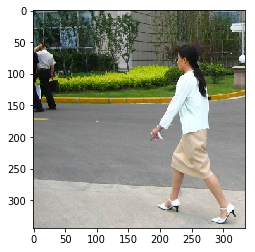

In [119]:
plt.imshow(img_orig);

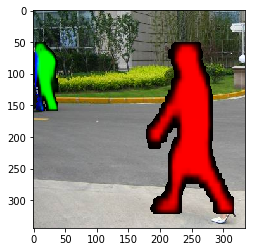

In [118]:
im = Image.fromarray(result.astype(numpy.uint8))
img_overlay = img_orig.copy()
img_overlay.paste(im, mask=mask)
plt.imshow(img_overlay);

## End